In [1]:
import sys
import pandas as pd

import numpy as np
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns 
from os import path

from glob import glob
import json

In [2]:
def compute_k(accs, changes, ss):
    HR = np.sum(accs*changes) / np.sum(changes)
    FA = np.sum((~accs)*(~changes)) / np.sum(~changes)
    return ss*(HR - FA)

def get_k_by_ss(beh_mem):
    beh_mem.loc[:,'n_targets'] = beh_mem.n_targets.astype(int)  # convert to integers, in case they were strings

    setsizes = sorted(beh_mem.n_targets.unique())
    k_by_ss = {}
    for i,ss in enumerate(setsizes):
        curr_beh = beh_mem.query(f'n_targets=={ss}')
        # get accuracy and change trial info as boolean vectors
        accs = curr_beh.ACC.astype(float).astype(bool).values
        changes = np.array([c=='True' for c in curr_beh['change'].astype(str).values])
        k_by_ss[int(ss)] = compute_k(accs, changes, int(ss))
    return k_by_ss

In [3]:
experiment_name = "data/preprocessed"
data_dir = f"../{experiment_name}"


isub_makeup_error_trials = {'001': 2}  # after exclusion, the last n trials which need to be recovered, for now

In [15]:
sub_files = sorted(glob(path.join(data_dir, "*/*data.csv")))

In [26]:
old_beh_format = ['001', '002']

In [30]:
k_res = {}
k_res_wPlaceholders = {}
k_res_noPlaceholders = {}
attn_res = {}

for bfile in sub_files:
    subid = bfile.split('/')[-2]

    beh = pd.read_csv(bfile)
    beh = beh.loc[~(beh.REJ==1)] # remove real time eye tracking rejects, which aren't in the EEG

    artifact_idx = np.load(bfile.replace('_data.csv', '_rej_FINAL.npy'))
    artifact_idx = ~artifact_idx.astype(bool)

    if subid=="010":
        beh = beh.iloc[4:]  # remove first 4 trials, for which recording wasn't running
    beh = beh.loc[artifact_idx]

    if 'RESP' not in beh.columns:
        print(f'Warning: Resp not in beh columns for sub {subid}')

    if subid in old_beh_format:
        beh_attn = beh.loc[beh["Block Condition"] == 'attention']
    else:
        beh_attn = beh.loc[beh["block_condition"] == 'attention']
    attn_res[subid] = beh_attn.query("target_present==1.0").groupby('n_targets').ACC.mean()

    # exclude trials where numbers appears
    numbers_absent = (beh.target_present==0).values
    beh = beh.loc[numbers_absent]

    # get K per set size
    if subid in old_beh_format:
        beh_mem = beh.loc[beh['Block Condition']=='memory']
    else:
        beh_mem = beh.loc[beh['block_condition']=='memory']
    sub_ks = get_k_by_ss(beh_mem)
    k_res[subid.zfill(3)] = sub_ks

    # separate by placeholder presence
    placeholder_idx = beh_mem.trial_condition.str.contains('P').values
    beh_mem_placeholder = beh_mem.loc[placeholder_idx]
    k_res_wPlaceholders[subid.zfill(3)] = get_k_by_ss(beh_mem_placeholder)

    beh_mem_noPlaceholder = beh_mem.loc[~placeholder_idx]
    k_res_noPlaceholders[subid.zfill(3)] = get_k_by_ss(beh_mem_noPlaceholder)

,0
001,4.591170
002,1.055957
003,4.539708
004,3.805924
005,2.025422
007,2.535265
008,4.179959
009,4.163418
010,3.831069
011,3.994695


In [31]:
json.dump(k_res, open('k_estimates.json', 'w'))
json.dump(k_res_wPlaceholders, open('k_estimates_wPlaceholders.json', 'w'))
json.dump(k_res_noPlaceholders, open('k_estimates_noPlaceholders.json', 'w'))

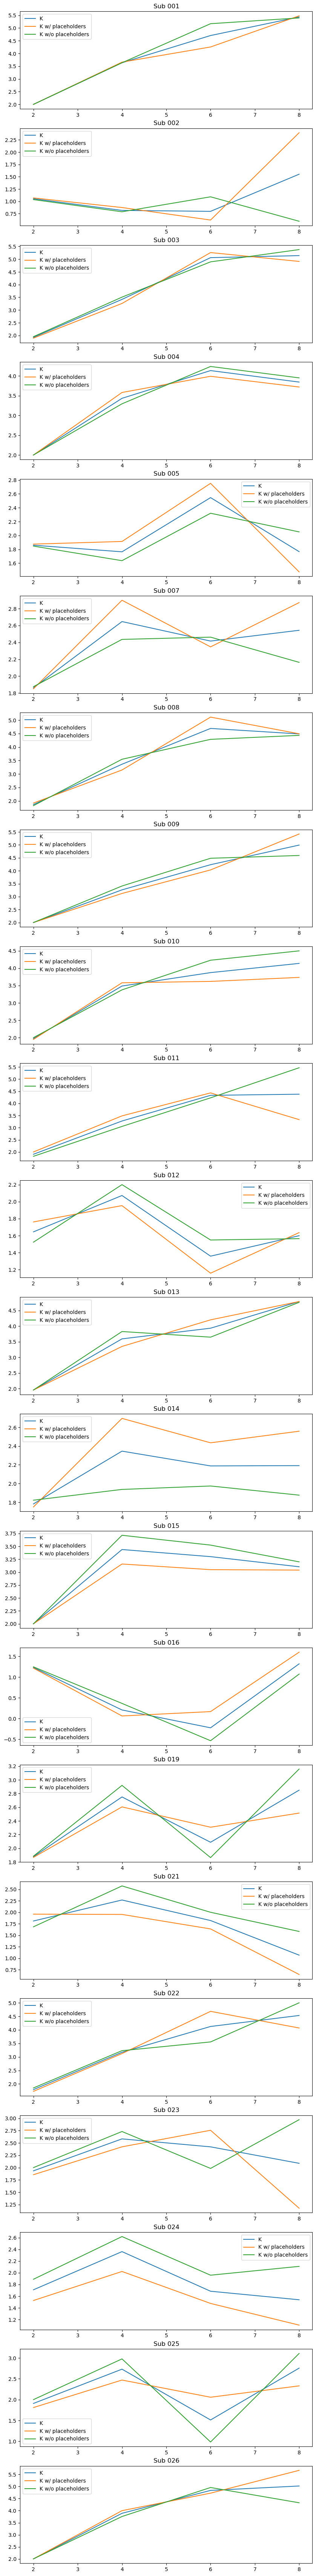

In [32]:
fig, axes = plt.subplots(len(k_res.keys()),1, figsize=(10,len(k_res.keys())*4))
for i,subid in enumerate(k_res):
    for dict_name, k_dict in {'K': k_res, 'K w/ placeholders': k_res_wPlaceholders, 'K w/o placeholders': k_res_noPlaceholders}.items():
        sub_ks = k_dict[subid]
        sub_ks = np.array([[int(k),v] for k,v in sub_ks.items()]) 
        ax = sns.lineplot(x=sub_ks[:,0], y=sub_ks[:,1], ax=axes[i], label=dict_name)
    ax.title.set_text(f'Sub {subid}')
    # axes[i].legend(['K', 'K w/ placeholders', 'K w/o placeholders'])
    # plt.legend()
plt.show()
plt.close()

# Spatial Attention Task

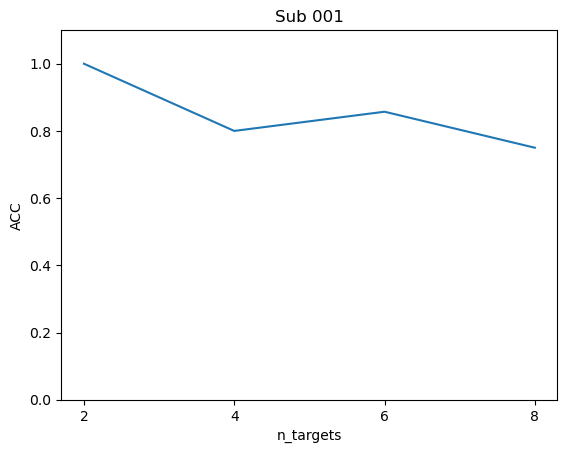

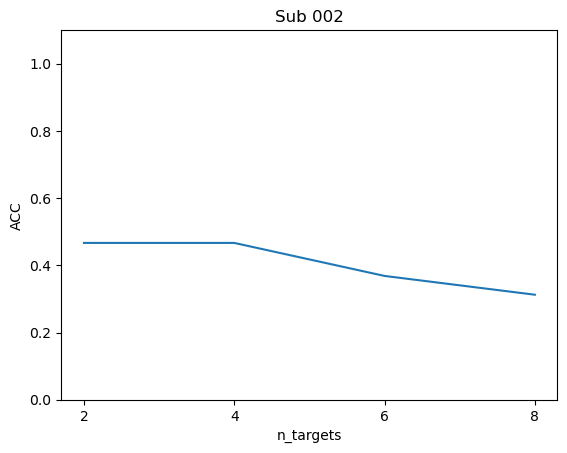

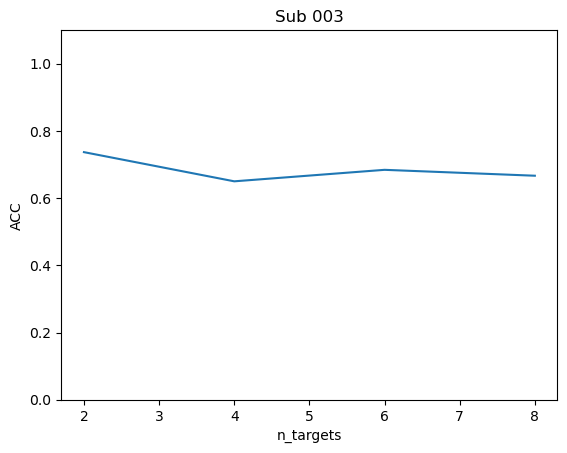

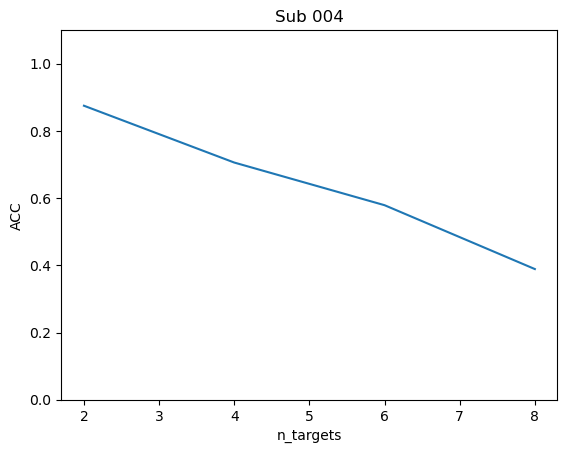

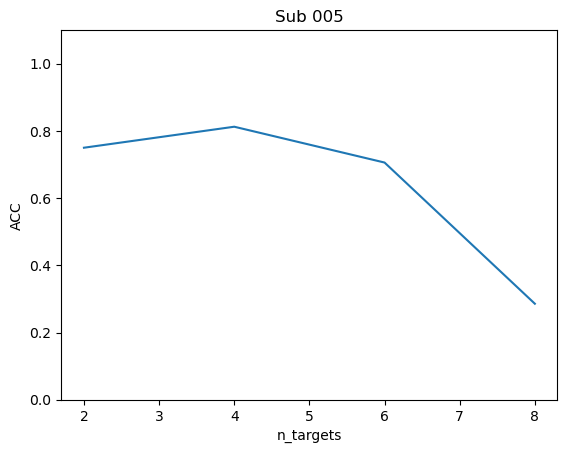

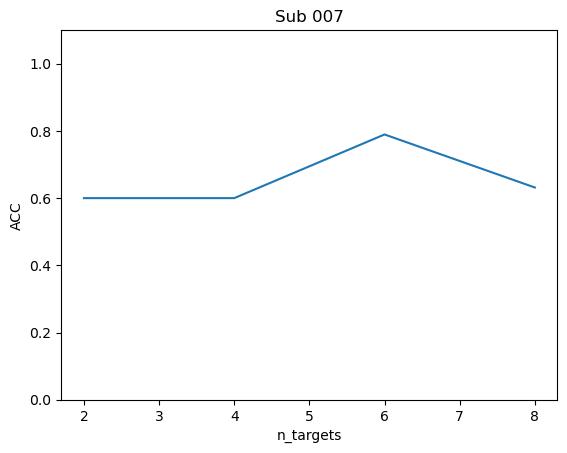

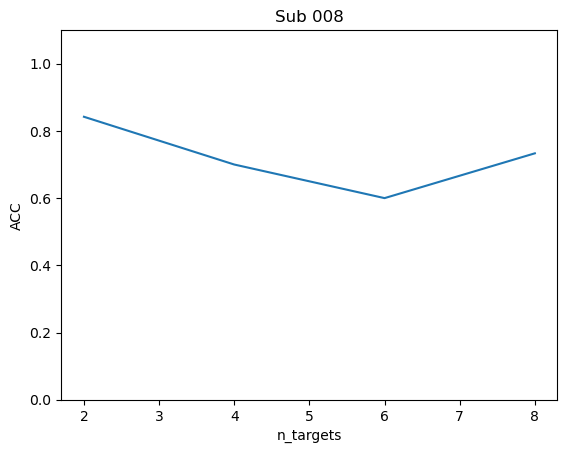

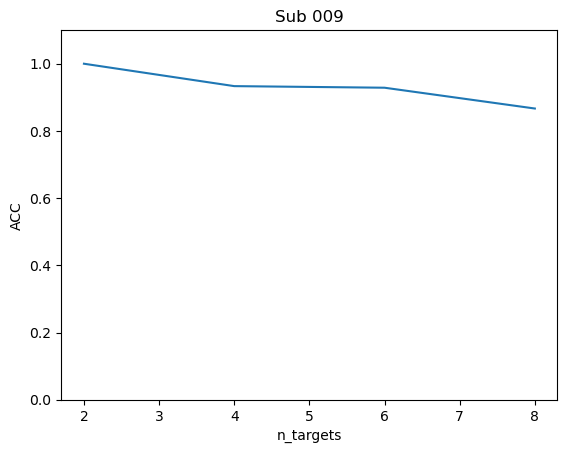

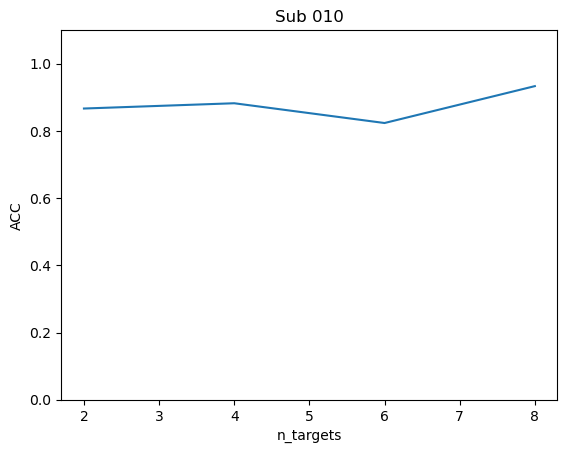

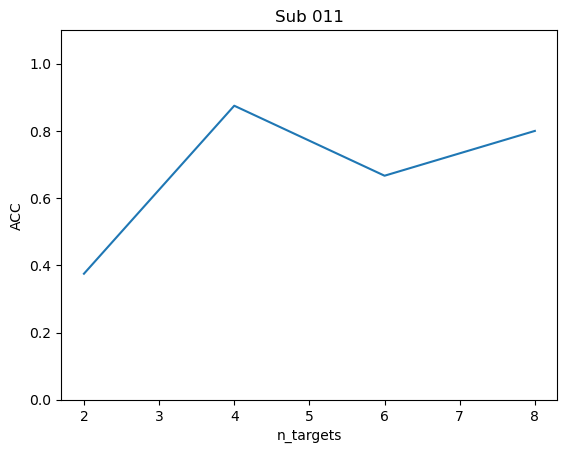

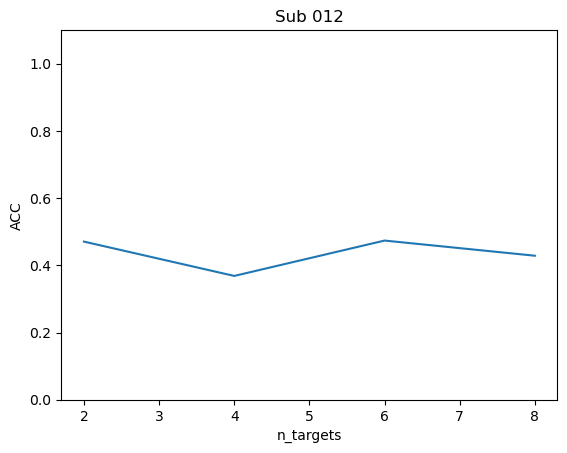

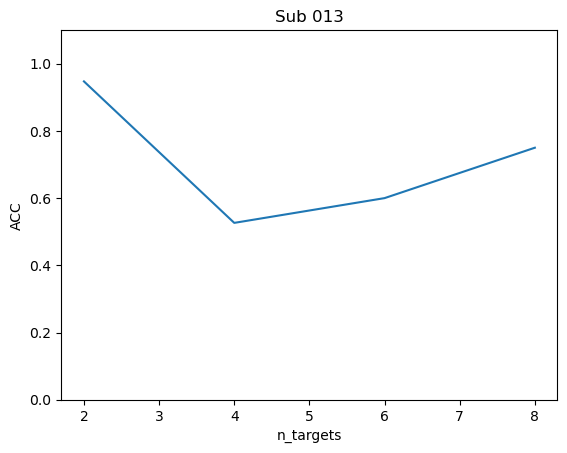

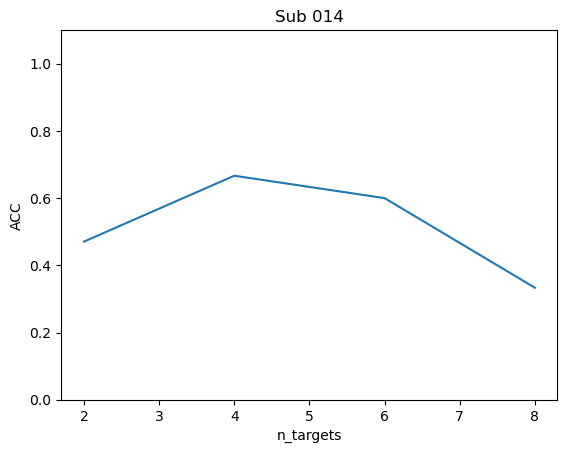

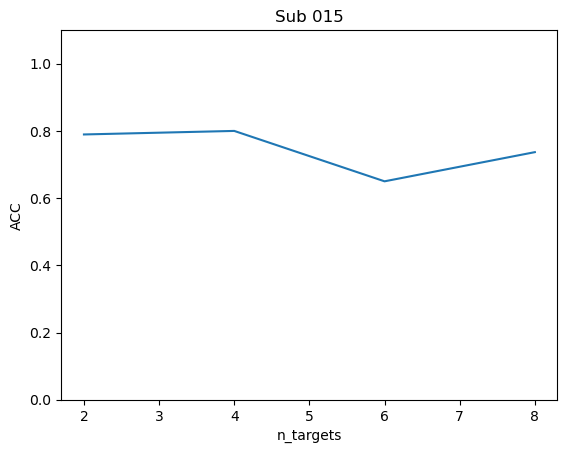

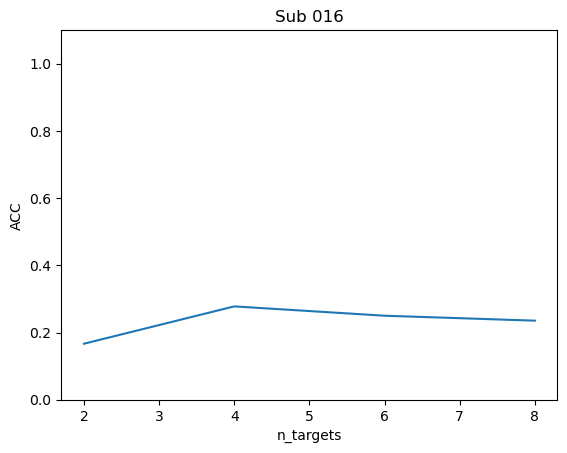

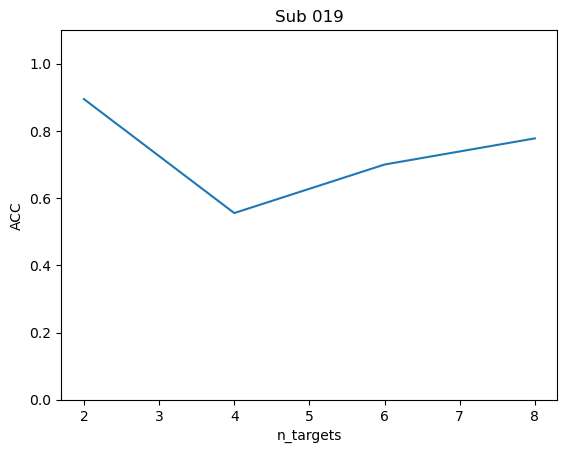

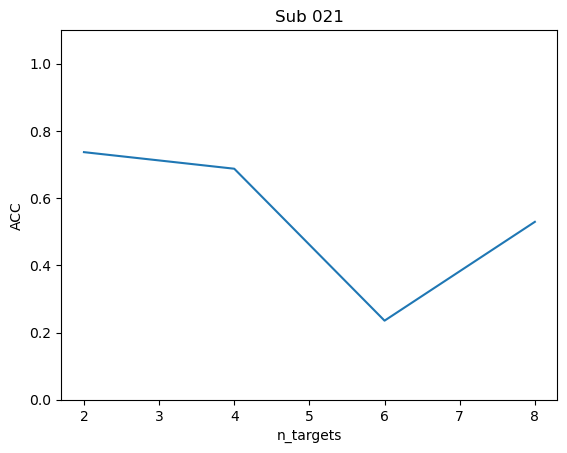

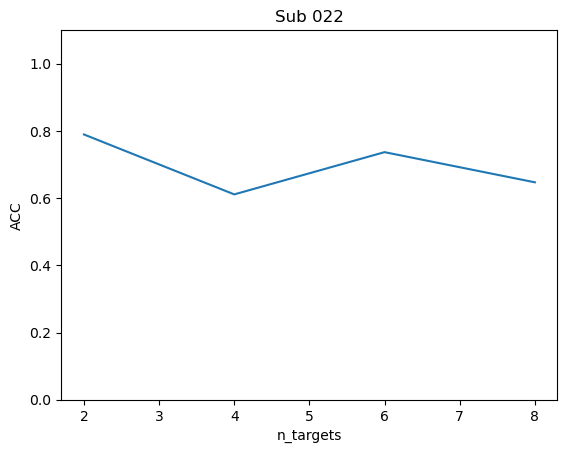

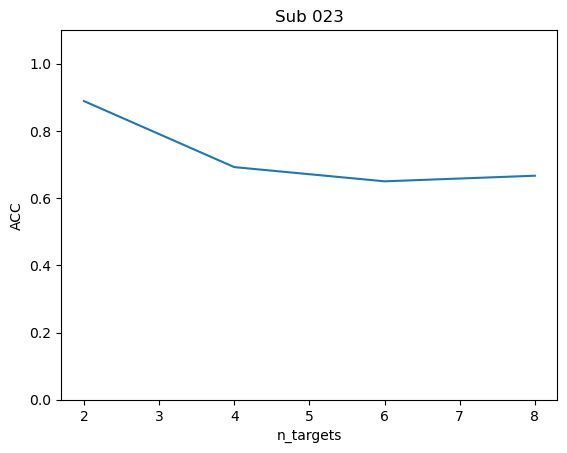

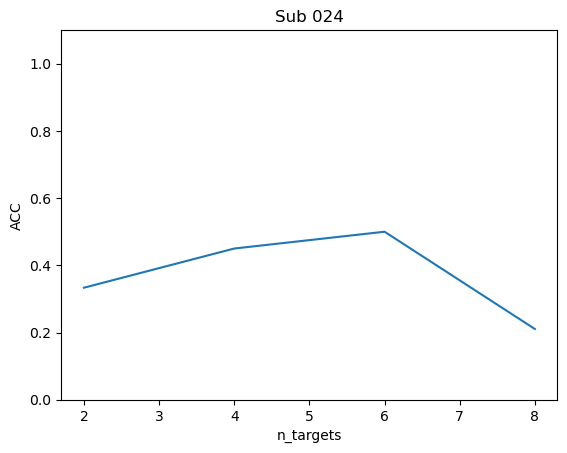

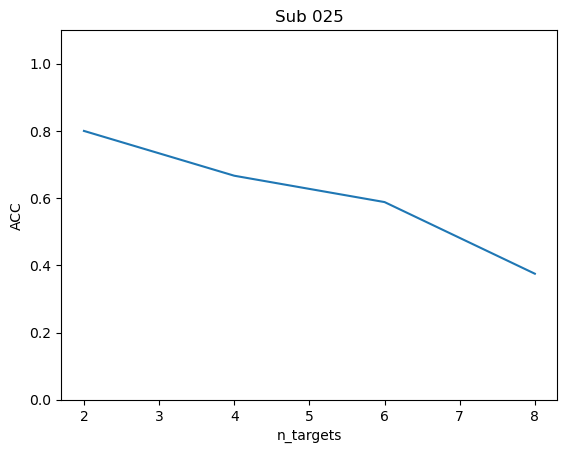

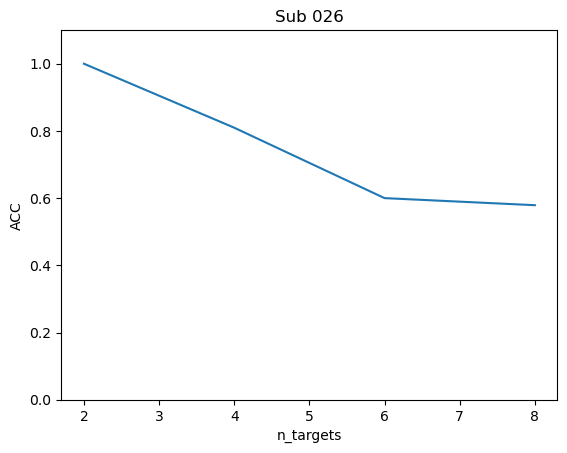

In [33]:
for i,subid in enumerate(attn_res):
    ax = sns.lineplot(pd.DataFrame(attn_res[subid]),
             x='n_targets',
             y='ACC'
             )
    ax.set_ylim([0,1.1])
    ax.set_title(f'Sub {subid}')
    plt.show()
    plt.close()